In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import intake

# Import Cdo-py
import cdo
cdo = cdo.Cdo(tempdir='/scratch/u/u233156/tmp/cdo-py') #change the tempdir to your scratch

import pickle

import os
    
plotdir = './plots/precip/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)  

def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

def convert_to_xarray_cycle2(ds,var,grid='1'):
    # select a variable, reshape lat lon and convert to XArray DataArray
    # needs to specify an existing varname e.g. '2t'
    # assumes that ds has the shape time | value
    
    # arrange value coordinate into lat/lon
    sample = np.reshape(ds[var].values, newshape=(len(ds.time),len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    
    # create DataArray with proper name, dimensions, and coordinates
    da = xr.DataArray(
        data=sample,
        name=var,
        dims=["time", "lat", "lon"],
        coords=dict(
            time=ds.time.data,
            lon=(["lon"], np.unique(ds.lon)),
            lat=(["lat"], np.unique(ds.lat)),
            #lat=(["lat"], np.unique(ds.lat)[::-1]), # use this because otherwise lats are flipped; only comment for testing
        ),
        attrs=dict(
            # variable=var,
        ),
    )
    
    # attach griddes so that cdo interprets it as a regular lonlat grid:
    if grid=='1':
        my_griddes = '/work/bm1235/u233156/ifs-grids/multio_grids_cdoPython/1_griddes_latrevert'
    else:
        raise Exception("Unsupported grid. Maybe new grid introduced in multIO?")
        
    da = cdo.setgrid(my_griddes, input=da.to_dataset(), returnXDataset=True)[var]
    
    return da

In [4]:
# THIS STEP IS ONLY NECESSARY IF PICKLE IS NOT USED!!

cat = intake.open_catalog("https://nextgems.github.io/catalog/catalog.yaml")

# which IFS experiments are available? Which streams are in the IFS catalog for experiment 'tco2559-ng5-cycle3'?
print(list(cat.IFS))
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3'])) 


array_yea= ["2020"]
array_mon= ["01","02","03","04","05","06","07","08","09","10","11","12"]

array_exp      = ["IFS_4.4-FESOM_5-cycle3","ifs_cycle2_4km_tp","IFS_9-NEMO_25-cycle3","ifs_cycle2_9km_tp","IFS_9-FESOM_5-cycle3","ifs_cycle2_3km_tp"]
# FESOM family is red, NEMO family blue
array_color    = ["#ff0000","#ff0000","#0000ff","#0000ff","purple","darkorange"]
# give IFS resolution only, FESOM/NEMO don't change from 25/5km
array_labels   = ["Cycle 3, 4.4km, IFS-FESOM","Cycle 2, 4.4km, IFS-FESOM","Cycle 3, 9km, IFS-NEMO","Cycle 2, 9km, IFS-NEMO","Cycle 3, 9km, IFS-FESOM","Cycle 2, 2.8km, IFS-FESOM"]
# Cycle 3 is solid, Cycle 2/1 dashed
array_linestyle= ["solid","dashed","solid","dashed","solid","dashed"]
# main simulation is thicker to stand out
array_linewidth= [2,1,1,1,1,1]



dask_dict = {}
for a,exp in enumerate(array_exp):
 if  array_linestyle[a] == "solid":      
    data = cat.IFS[f'{exp}']['2D_monthly_0.25deg'].to_dask().pipe(attach_coords)['tp'].groupby("lat").mean() # load medium-resolution here, monthly means (entire time series), zonal mean      
    year_idxs=data.groupby('time.year').groups  
    idxs_year=year_idxs[int(array_yea[0])] 
    data_year=data.isel(time=idxs_year) 
    month_idxs=data_year.groupby('time.month').groups
 
    for m in range(len(array_mon)):
        mon=m+1
        idxs=month_idxs[mon]
        dask_dict[a,m]=data_year.isel(time=idxs)   
 else:
    ds_cycle2_9km_tp=xr.open_dataset("/work/bm1235/a270046/cycle2-sync/monthly_means/9km/tp_9km.nc")
    ds_cycle2_4km_tp=xr.open_dataset("/work/bm1235/a270046/cycle2-sync/monthly_means/4km/tp_4km.nc")
    ds_cycle2_3km_tp=xr.open_dataset("/work/bm1235/a270046/cycle2-sync/monthly_means/2.8km/tp_2.8km.nc")

    ifs_cycle2_9km_tp = convert_to_xarray_cycle2(ds_cycle2_9km_tp,var='tp',grid='1')
    ifs_cycle2_4km_tp = convert_to_xarray_cycle2(ds_cycle2_4km_tp,var='tp',grid='1')
    ifs_cycle2_3km_tp = convert_to_xarray_cycle2(ds_cycle2_3km_tp,var='tp',grid='1')
    
    data = globals()[f'{exp}'].groupby("lat").mean(dim="lon") # load medium-resolution here, monthly means (entire time series), zonal mean      
    year_idxs=data.groupby('time.year').groups  
    idxs_year=year_idxs[int(array_yea[0])] 
    data_year=data.isel(time=idxs_year) 
    month_idxs=data_year.groupby('time.month').groups
    for m in range(len(array_mon)):
        mon=m+1
        if mon <= len(month_idxs):
         idxs=month_idxs[mon]
         dask_dict[a,m]=data.isel(time=idxs)  
        else:
         dask_dict[a,m]=0 
        
        
        
        
indir_GPM   = "/work/bm1235/observations/GPM_IMERG/"

PrG = {}
PrGclim = {}
PrGmin = {}
PrGmax = {}

for i,mon in enumerate(array_mon):
    file=f'{indir_GPM}/GPM_IMERG_hourly_2020_{mon}_timmean.nc'
    Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
    Pr = np.mean(Pr[:,:],2) # average over all lons
    PrG[i] = np.squeeze(Pr) *24
    file=f'{indir_GPM}/GPM_IMERG_hourly_2010to2020_month_{mon}_timmean.nc'
    Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
    Pr = np.mean(Pr[:,:],2) # average over all lons
    PrGclim[i] = np.squeeze(Pr) *24
    file=f'{indir_GPM}/GPM_IMERG_monthly_2010to2020_{mon}_zonmean_timmin.nc'
    Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
    Pr = np.mean(Pr[:,:],2) # average over all lons
    PrGmin[i] = np.squeeze(Pr) *24
    file=f'{indir_GPM}/GPM_IMERG_monthly_2010to2020_{mon}_zonmean_timmax.nc'
    Pr = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
    Pr = np.mean(Pr[:,:],2) # average over all lons
    PrGmax[i] = np.squeeze(Pr) *24
    
# WRITE PICKLE

# Open a file and use dump()
with open('../data/precip_monthly.pickle', 'wb') as file:
      
    # A new file will be created
    pickle.dump([dask_dict,PrG,PrGmin,PrGmax,PrGclim], file)  

['IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_grids']
['2D_1h_native', '3D_1h6h_native', '2D_monthly_native', '3D_monthly_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_1h_0.25deg', '3D_1h6h_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', '2D_1h_1deg', '3D_1h6h_1deg', 'WAM_1h_native']


In [2]:
# CONTINUE HERE IF PICKLE IS USED

with open(f'../data/precip_monthly.pickle', 'rb') as file:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    dask_dict,PrG,PrGmin,PrGmax,PrGclim = pickle.load(file)

01
IFS_4.4-FESOM_5-cycle3
Cycle 3, 4.4km, IFS-FESOM
ifs_cycle2_4km_tp
Cycle 2, 4.4km, IFS-FESOM
IFS_9-NEMO_25-cycle3
Cycle 3, 9km, IFS-NEMO
ifs_cycle2_9km_tp
Cycle 2, 9km, IFS-NEMO
IFS_9-FESOM_5-cycle3
Cycle 3, 9km, IFS-FESOM
ifs_cycle2_3km_tp
Cycle 2, 2.8km, IFS-FESOM
02
IFS_4.4-FESOM_5-cycle3
Cycle 3, 4.4km, IFS-FESOM
ifs_cycle2_4km_tp
Cycle 2, 4.4km, IFS-FESOM
IFS_9-NEMO_25-cycle3
Cycle 3, 9km, IFS-NEMO
ifs_cycle2_9km_tp
Cycle 2, 9km, IFS-NEMO
IFS_9-FESOM_5-cycle3
Cycle 3, 9km, IFS-FESOM
ifs_cycle2_3km_tp
Cycle 2, 2.8km, IFS-FESOM
03
IFS_4.4-FESOM_5-cycle3
Cycle 3, 4.4km, IFS-FESOM
ifs_cycle2_4km_tp
Cycle 2, 4.4km, IFS-FESOM
IFS_9-NEMO_25-cycle3
Cycle 3, 9km, IFS-NEMO
ifs_cycle2_9km_tp
Cycle 2, 9km, IFS-NEMO
IFS_9-FESOM_5-cycle3
Cycle 3, 9km, IFS-FESOM
ifs_cycle2_3km_tp
Cycle 2, 2.8km, IFS-FESOM
04
IFS_4.4-FESOM_5-cycle3
Cycle 3, 4.4km, IFS-FESOM
ifs_cycle2_4km_tp
Cycle 2, 4.4km, IFS-FESOM
IFS_9-NEMO_25-cycle3
Cycle 3, 9km, IFS-NEMO
ifs_cycle2_9km_tp
Cycle 2, 9km, IFS-NEMO
IFS_9-FES

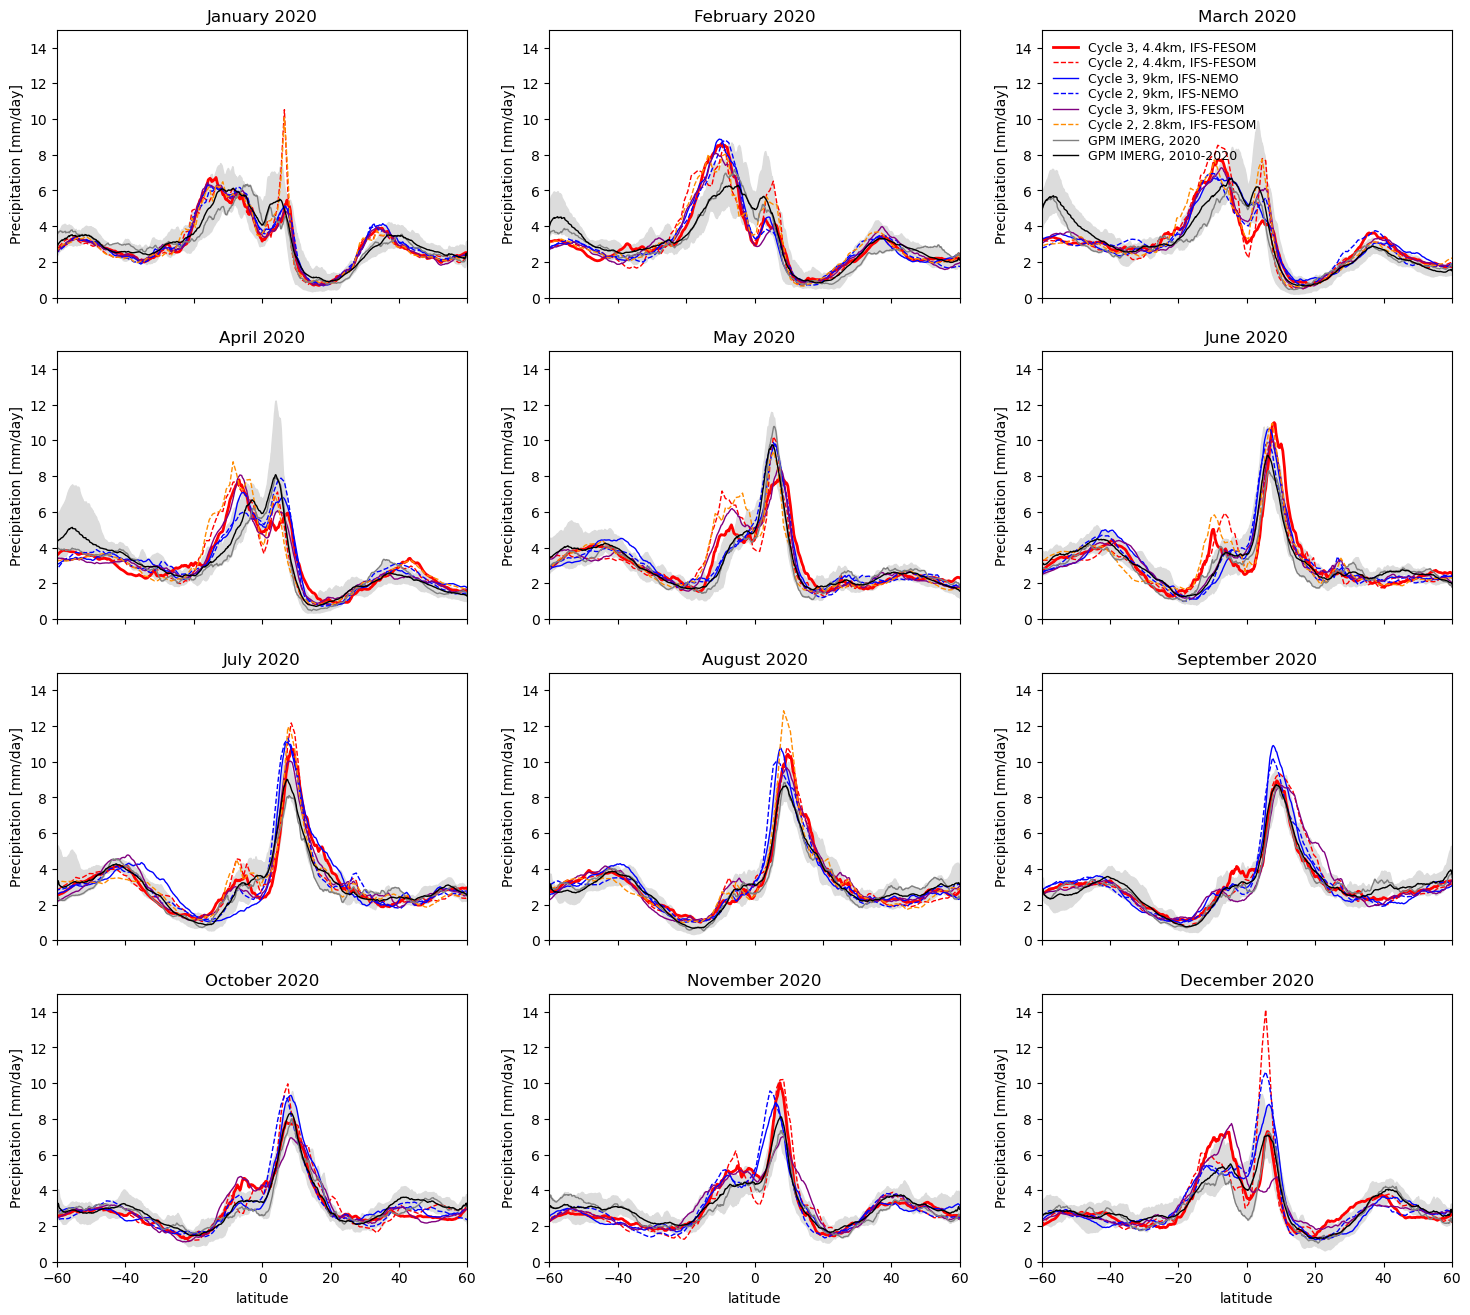

In [4]:
array_yea= ["2020"]
array_mon= ["01","02","03","04","05","06","07","08","09","10","11","12"]

array_exp      = ["IFS_4.4-FESOM_5-cycle3","ifs_cycle2_4km_tp","IFS_9-NEMO_25-cycle3","ifs_cycle2_9km_tp","IFS_9-FESOM_5-cycle3","ifs_cycle2_3km_tp"]
# FESOM family is red, NEMO family blue
array_color    = ["#ff0000","#ff0000","#0000ff","#0000ff","purple","darkorange"]
# give IFS resolution only, FESOM/NEMO don't change from 25/5km
array_labels   = ["Cycle 3, 4.4km, IFS-FESOM","Cycle 2, 4.4km, IFS-FESOM","Cycle 3, 9km, IFS-NEMO","Cycle 2, 9km, IFS-NEMO","Cycle 3, 9km, IFS-FESOM","Cycle 2, 2.8km, IFS-FESOM"]
# Cycle 3 is solid, Cycle 2/1 dashed
array_linestyle= ["solid","dashed","solid","dashed","solid","dashed"]
# main simulation is thicker to stand out
array_linewidth= [2,1,1,1,1,1]


# calendar plot for all years in one
fig, axs = plt.subplots(4,3, figsize=(18, 16), sharex=True, sharey=False)

                   

# set labels
plt.setp(axs[-1], xlabel='latitude') # only plot this for the last element
plt.setp(axs[:], ylabel='Precipitation [mm/day]')
plt.setp(axs[:], xlim=(-60, 60))
plt.setp(axs[:], ylim=(0, 15))
plt.yticks()    

for y,yea in enumerate(array_yea):  
    
 Title= [f'January {yea}',f'February {yea}',f'March {yea}',f'April {yea}',f'May {yea}',f'June {yea}',f'July {yea}',f'August {yea}',f'September {yea}',f'October {yea}',f'November {yea}',f'December {yea}']
 #subplot_label= ["(a)","(b)","(c)","(d)"]

 for mon,(i,ax) in zip(array_mon,enumerate(axs.flat)):  
     print(mon)
     ax.set_title(Title[i])

     ax.fill_between(PrGmin[i].lat, PrGmin[i], PrGmax[i],
          color="gainsboro",)      
    
 
     for (a,exp),color,labels,linestyle,linewidth in zip(enumerate(array_exp),array_color,array_labels,array_linestyle,array_linewidth):          
         if not isinstance(dask_dict[a,i], int):
           print(exp)     
           filP_y = np.squeeze(dask_dict[a,i]) *1000 *86400    
           print(labels)
           ax.plot(filP_y.lat,
                   filP_y,
                   color=color,
                   linestyle=linestyle,
                   label=labels,
                   linewidth=linewidth)  

     filPrG=PrG[i]
     ax.plot(filPrG.lat,
          filPrG,
          color="grey",
          linestyle='solid',
          label="GPM IMERG, 2020",
          linewidth=1)    
    
     filPrGclim=PrGclim[i]
     ax.plot(filPrGclim.lat,
          filPrGclim,
          color="black",
          linestyle='solid',
          label="GPM IMERG, 2010-2020",
          linewidth=1)    
    
     if i==2:
      # Add legend
      handles, labels = ax.get_legend_handles_labels()
      ax.legend(handles,
          labels,
          loc='upper left',
          frameon=False,
          fontsize=9,
          labelspacing=.2)

     #ax.tick_params(axis='y', labelsize=18)              
     #ax.tick_params(axis='x', labelsize=18)        
     
     #ax.annotate(subplot_label[i], xy=(0.9, 0.9), xycoords="axes fraction")

fig.savefig(plotdir + 'precip_zonmean_NextGEMS_Cycle2_vs_3_GPM_filled_monthly_2020.png')  
fig.savefig(plotdir + 'precip_zonmean_NextGEMS_Cycle2_vs_3_GPM_filled_monthly_2020.pdf')